<h1><center> <span style="color:blue"><br> IBM: Data Science Couse Capstone </span><h1>
    

<h3><center> The purpose of this notebook is to provide adequate data on the neighbourhoods of Toronto, so a person who wishes to open a restaurant in the area can choose the best nieghbourhood fo their needs.The first step of the process was to find a list of all neighbourhoods in Toronto, this was one by scraping a wikipedia page and strong the neibourhoods in a data frame <center><h3>

<h3><span style="color:blue"><u>Obtaining Data<u></span><h3>

### Step 1: Import all the needed libraries 

In [271]:
#imports
import pandas as pd
import numpy as np
import requests
from requests import get 
import lxml.html as lh
import geocoder
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Step 2: Scrape the Wikipedia Page to get the names of the neighbourhoods 

In [6]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'           #the website which we are using for our data 
response=get(url)                                                               #request the content of the webpage from the server and store it in the variable 'respose'

In [7]:
doc = lh.fromstring(response.content)                                           #storing the contents of website in a document
tr_elements = doc.xpath('//tr')                                                 #extracting the data stored between <tr></tr> tags (which define a table)
#create an empty list to store the table data in 
col=[]
i=0
#stroing the headers
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))
    
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    #this is to ensure that each row has the same length
    if len(T)!=3:
        break
    i=0
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #if there is any numerical data convert it into integers 
            try:
                data=int(data)
            except:
                pass
        #Append the data
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

### Step 3: Store the Nieghbourhood information a Pandas data frame

In [8]:
#create the dataframe 
Dict={title:column for (title,column) in col}
df_neighbourhood=pd.DataFrame(Dict)
print(df_neighbourhood.shape)
df_neighbourhood.head()

(287, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


 <h3><span style="color:blue">DATA CLEANING</span><h3>

In [9]:
#removing all the columns which do not have an assigned Borough
df_neighbourhood=df_neighbourhood[df_neighbourhood.Borough!="Not assigned"]
print(df_neighbourhood.shape)
df_neighbourhood=df_neighbourhood.reset_index(drop=True)       #reset the index 
df_neighbourhood.rename(columns={'Neighbourhood\n':'Neighbourhood'},inplace=True)    #renaming column to replace '\n' character
df_neighbourhood['Neighbourhood'] = df_neighbourhood['Neighbourhood'].map(lambda x: x.rstrip('\n'))   #removing the '\n' that appears after the neighbourhoods
df_neighbourhood.head()

(210, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [10]:
df_neighbourhood=df_neighbourhood.groupby('Postcode').agg(lambda x: ','.join(set(x)))   #groupby postcode and combine rows with same postcode 
df_neighbourhood=df_neighbourhood.reset_index(drop=False)
df_neighbourhood.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill"
2,M1E,Scarborough,"Morningside,West Hill,Guildwood"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
#if a cell as an assigned Borough but not neighbourhood then the burough becomes thw neighbourhood 
df_neighbourhood['Neighbourhood']=np.where(df_neighbourhood['Neighbourhood']=='Not assigned',df_neighbourhood['Borough'],df_neighbourhood['Neighbourhood'])

In [9]:
df_neighbourhood.shape

(103, 3)

In [12]:
#downlaod longtitude and latitude data 
!wget -q -O 'longandlat_data.csv' https://cocl.us/Geospatial_data
long_lat_df=pd.read_csv('longandlat_data.csv')
long_lat_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
#append the logtitude and latitude columns to df_neighbourhood 
df_neighbourhood['Latitude']=long_lat_df['Latitude']
df_neighbourhood['Longitude']=long_lat_df['Longitude']
df_neighbourhood.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Port Union,Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Morningside,West Hill,Guildwood",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h3><span style="color:blue">NEIGHBOURHOOD SEGMENTATION</span><h3> 

<h3> Defining the Foursqaure API credientials and Version <h3>

In [14]:
# The code was removed by Watson Studio for sharing.

<h3> Creating the geolocater instance <h3>

In [15]:
address='Toronto, TO'
geolocater=Nominatim(user_agent="toronto_explorer")
location = geolocater.geocode(address)                     
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


<h3> Creating a map of Toronto and adding markers to represent each nieghbourhood <h3>

In [16]:
toronto_map=folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,long,borough,neighbourhood in zip(df_neighbourhood['Latitude'],df_neighbourhood['Longitude'],df_neighbourhood['Borough'],df_neighbourhood['Neighbourhood']):
                label='{},{}'.format(neighbourhood,borough)
                label=folium.Popup(label,parse_html=True)
                folium.CircleMarker(
                [lat,long],
                raduis=5,
                popup=label,
                color='',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6,
                parse_html=True
                ).add_to(toronto_map)
display(toronto_map)

<h3> Exploring the Data <h3>

 ### Extracting all the restraunts of Toronto and thier correspoding neighbourhoods

In [17]:
LIMIT=5000
def getNearbyRestaurants(names, latitudes, longitudes, radius=5000,categoryId=''):
    restaurant_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if(categoryId!=''):
            url=url+'&categoryId={}'
            url=url.format(categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # retrun only the venue name, corrdinates and catagoery
        restaurant_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_restaurant = pd.DataFrame([item for restaurant_list in restaurant_list for item in restaurant_list])
    nearby_restaurant.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'restaurant', 
                  'restaurant Latitude', 
                  'restaurant Longitude', 
                  'restaurant Category']
    
    return(nearby_restaurant)   

In [44]:
all_restaurants=getNearbyRestaurants(names=df_neighbourhood['Neighbourhood'], latitudes=df_neighbourhood['Latitude'], longitudes=df_neighbourhood['Longitude'], radius=1000, categoryId='4d4b7105d754a06374d81259')

In [47]:
all_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,restaurant,restaurant Latitude,restaurant Longitude,restaurant Category
0,"Malvern,Rouge",43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
1,"Malvern,Rouge",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
2,"Malvern,Rouge",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,"Malvern,Rouge",43.806686,-79.194353,Harvey's,43.800106,-79.198258,Fast Food Restaurant
4,"Malvern,Rouge",43.806686,-79.194353,Mr Jerk,43.801262,-79.199758,African Restaurant


In [97]:
all_restaurants_grouped=all_restaurants.groupby('Neighborhood').size().to_frame('count').reset_index()
all_restaurants_grouped.reset_index(inplace=True)
all_restaurants_grouped.head()

,index,Neighborhood,count
0,0,"Adelaide,Richmond,King",100
1,1,Agincourt,42
2,2,"Alderwood,Long Branch",5
3,3,Bayview Village,5
4,4,"Bedford Park,Lawrence Manor East",25


### Using this information to create a Bar Graph

In [111]:
#first order the data frame, in descending order, in terms of number of resturnats 
all_restaurants_ordered=all_restaurants_grouped.sort_values(by='count',ascending=False)
all_restaurants_ordered.head(20)
all_resturant_top_20=all_restaurants_ordered.iloc[0:20]

,index,Neighborhood,count
60,60,Queen's Park,104
0,0,"Adelaide,Richmond,King",100
81,81,"The Annex,Yorkville,North Midtown",100
79,79,Stn A PO Boxes 25 The Esplanade,100
18,18,Davisville,100


Text(0.5, 1.0, 'Nieghbourhoods with most Restaurants in Toronto')

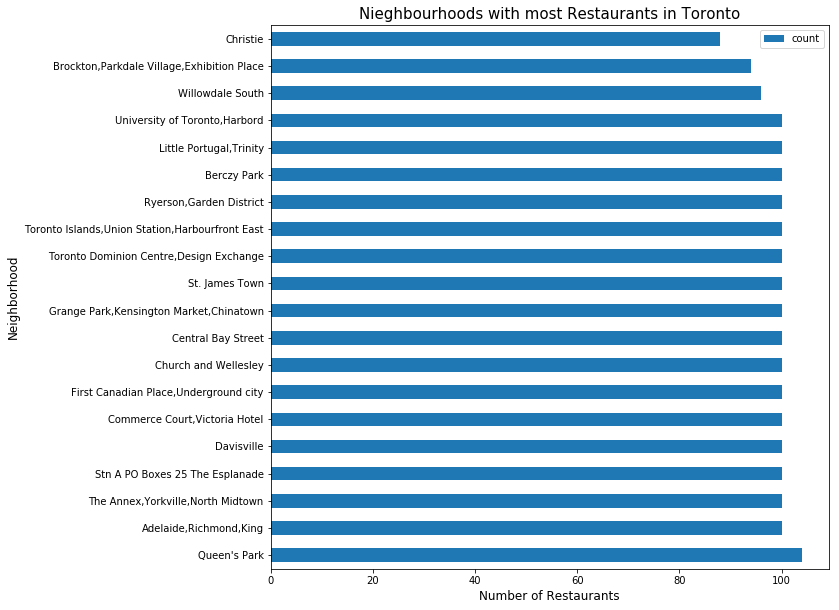

In [132]:
#now create the bar plot 
all_resturant_top_20.plot('Neighborhood','count',kind='barh',figsize=(10,10))
plt.ylabel("Neighborhood",fontsize=12)
plt.xlabel("Number of Restaurants",fontsize=12)
plt.title('Nieghbourhoods with most Restaurants in Toronto',fontsize=15)

<h1><span style="color:blue">Finding the top 5 resturant types for each neighbourhood</span><h1>

In [289]:
all_restaurants_onehot=pd.get_dummies(all_restaurants[['restaurant Category']], prefix="", prefix_sep="")
all_restaurants_onehot['Neighborhood'] = all_restaurants['Neighborhood'] 
fixed_columns = [all_restaurants_onehot.columns[-1]] + list(all_restaurants_onehot.columns[:-1])
all_restaurants_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,...,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Malvern,Rouge"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Malvern,Rouge"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Malvern,Rouge"
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Malvern,Rouge"
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Malvern,Rouge"


### Now we will sort by Neighbourhood and calculate the mean frequency occurance of each category 


In [203]:
all_restaurants_one_grouped = all_restaurants_onehot.groupby('Neighborhood').mean().reset_index()
all_restaurants_one_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,"Adelaide,Richmond,King",0.0,0.0,0.04000,0.0,0.0,0.030000,0.00000,0.00,0.030000,...,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.03,0.00000,0.00
1,Agincourt,0.0,0.0,0.02381,0.0,0.0,0.047619,0.02381,0.00,0.047619,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.02381,0.00
2,"Alderwood,Long Branch",0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.00,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00000,0.00
3,Bayview Village,0.0,0.0,0.00000,0.0,0.0,0.000000,0.00000,0.00,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00000,0.00
4,"Bedford Park,Lawrence Manor East",0.0,0.0,0.04000,0.0,0.0,0.000000,0.00000,0.04,0.040000,...,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.00,0.00000,0.04


### Now we will calculate the top 5 types of resturants in each Neighbouhood 

In [276]:
for hood in all_restaurants_one_grouped ['Neighborhood']:
    temp = all_restaurants_one_grouped [all_restaurants_one_grouped ['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [277]:
def return_most_common_res(row, num_top_venues):               #function that will sort the resturants in desecnding order 
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [278]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Resturant Type'.format(ind+1))

# create a new dataframe
neighborhoods_res_sorted = pd.DataFrame(columns=columns)
neighborhoods_res_sorted['Neighborhood'] = all_restaurants_one_grouped['Neighborhood']

for ind in np.arange(all_restaurants_one_grouped.shape[0]):
    neighborhoods_res_sorted.iloc[ind, 1:] = return_most_common_res(all_restaurants_one_grouped.iloc[ind, :], num_top_venues)

neighborhoods_res_sorted.head()

,Neighborhood,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Resturant Type,5th Most Common Resturant Type
0,"Adelaide,Richmond,King",Café,Restaurant,Japanese Restaurant,Italian Restaurant,Pizza Place
1,Agincourt,Chinese Restaurant,Asian Restaurant,Sandwich Place,Restaurant,Caribbean Restaurant
2,"Alderwood,Long Branch",Pizza Place,Sandwich Place,Donut Shop,Moroccan Restaurant,Wings Joint
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Fast Food Restaurant,Café,Wings Joint
4,"Bedford Park,Lawrence Manor East",Italian Restaurant,Pizza Place,Sushi Restaurant,Fast Food Restaurant,Thai Restaurant


<h1><span style="color:blue"> Clustering Neighbourhoods based on Resturant Types </span><h1>

In [279]:
k=15
resturant_grouped_cluster = all_restaurants_one_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(resturant_grouped_cluster)

In [280]:
neighborhoods_res_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_w_clusters_res = df_neighbourhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_w_clusters_res = toronto_w_clusters_res.join(neighborhoods_res_sorted.set_index('Neighborhood'), on='Neighbourhood')
toronto_w_clusters_res['Cluster Labels'] = toronto_w_clusters_res['Cluster Labels'].fillna("0").astype(int)
toronto_w_clusters_res['Cluster Labels'] = toronto_w_clusters_res['Cluster Labels'].astype('int32')
toronto_w_clusters_res.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Resturant Type,5th Most Common Resturant Type
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353,1,Fast Food Restaurant,Greek Restaurant,African Restaurant,Caribbean Restaurant,Chinese Restaurant
1,M1C,Scarborough,"Rouge Hill,Highland Creek,Port Union",43.784535,-79.160497,2,Breakfast Spot,Italian Restaurant,Burger Joint,Wings Joint,Food Court
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,8,Pizza Place,Fast Food Restaurant,Greek Restaurant,Fried Chicken Joint,Filipino Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Fish & Chips Shop,Indian Restaurant,Pizza Place,Restaurant,Chinese Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Bakery,Indian Restaurant,Chinese Restaurant,Wings Joint,Caribbean Restaurant


In [269]:
map_clusters_by_res = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_w_clusters_res['Latitude'], toronto_w_clusters_res['Longitude'], toronto_w_clusters_res['Neighbourhood'], toronto_w_clusters_res['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_by_res)
       
display(map_clusters_by_res)

In [295]:
cluster1=toronto_w_clusters_res.loc[toronto_w_clusters_res['Cluster Labels'] == 1]
cluster1.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Resturant Type,5th Most Common Resturant Type
0,M1B,Scarborough,"Malvern,Rouge",43.806686,-79.194353,1,Fast Food Restaurant,Greek Restaurant,African Restaurant,Caribbean Restaurant,Chinese Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Fish & Chips Shop,Indian Restaurant,Pizza Place,Restaurant,Chinese Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Bakery,Indian Restaurant,Chinese Restaurant,Wings Joint,Caribbean Restaurant
10,M1P,Scarborough,"Dorset Park,Wexford Heights,Scarborough Town C...",43.757410,-79.273304,1,Fast Food Restaurant,Asian Restaurant,Bakery,Chinese Restaurant,Indian Restaurant
11,M1R,Scarborough,"Maryvale,Wexford",43.750072,-79.295849,1,Middle Eastern Restaurant,Pizza Place,Burger Joint,Bakery,Seafood Restaurant


In [326]:
cluster7=toronto_w_clusters_res.loc[toronto_w_clusters_res['Cluster Labels'] == 7]
cluster7.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Resturant Type,5th Most Common Resturant Type
6,M1K,Scarborough,"Kennedy Park,Ionview,East Birchmount Park",43.727929,-79.262029,7,Chinese Restaurant,Pizza Place,Asian Restaurant,Sandwich Place,Fast Food Restaurant
12,M1S,Scarborough,Agincourt,43.794200,-79.262029,7,Chinese Restaurant,Asian Restaurant,Sandwich Place,Restaurant,Caribbean Restaurant
14,M1V,Scarborough,"L'Amoreaux East,Steeles East,Agincourt North,M...",43.815252,-79.284577,7,Chinese Restaurant,Pizza Place,Bakery,Noodle House,Fast Food Restaurant
15,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,7,Chinese Restaurant,Bakery,Fast Food Restaurant,Indian Restaurant,Noodle House
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,7,Pizza Place,Diner,Sandwich Place,Chinese Restaurant,Bakery
79,M6L,North York,"Upwood Park,Downsview,North Park",43.713756,-79.490074,7,Pizza Place,Sandwich Place,Chinese Restaurant,Bakery,Mediterranean Restaurant


<h1><span style="color:blue"> Exploring Other Venues </span><h1>

<h3> Entertainment Venues Nearby 

In [18]:
LIMIT=5000
def getEntertainmentbyRestaurants(names, latitudes, longitudes, radius=5000,categoryId=''):
    restaurant_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        if(categoryId!=''):
            url=url+'&categoryId={}'
            url=url.format(categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # retrun only the venue name, corrdinates and catagoery
        restaurant_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_entertainment = pd.DataFrame([item for restaurant_list in restaurant_list for item in restaurant_list])
    nearby_entertainment.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'restaurant', 
                  'restaurant Latitude', 
                  'restaurant Longitude', 
                  'restaurant Category']
    
    return(nearby_entertainment)          

In [328]:
all_entertainment=getNearbyRestaurants(names=df_neighbourhood['Neighbourhood'], latitudes=df_neighbourhood['Latitude'], longitudes=df_neighbourhood['Longitude'], radius=1000, categoryId='4d4b7104d754a06370d81259')

In [329]:
all_entertainment.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,restaurant,restaurant Latitude,restaurant Longitude,restaurant Category
0,"Malvern,Rouge",43.806686,-79.194353,Wood Bison Paddock,43.811732,-79.200708,Zoo Exhibit
1,"Rouge Hill,Highland Creek,Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
2,"Rouge Hill,Highland Creek,Port Union",43.784535,-79.160497,Framing dames,43.782590,-79.169369,Art Gallery
3,"Rouge Hill,Highland Creek,Port Union",43.784535,-79.160497,Unknown Artists (Base Camp),43.784272,-79.172938,Music Venue
4,Cedarbrae,43.773136,-79.239476,Taylor Dance Centre,43.776958,-79.246896,Country Dance Club


In [333]:
#group by neighbouhood 
all_entertainment_grouped=all_entertainment.groupby('Neighborhood').size().to_frame('count').reset_index()
all_entertainment_grouped.reset_index(inplace=True)
all_entertainment_grouped.head()

,index,Neighborhood,count
0,0,"Adelaide,Richmond,King",70
1,1,Agincourt,1
2,2,"Alderwood,Long Branch",5
3,3,Bayview Village,2
4,4,"Bedford Park,Lawrence Manor East",4


In [338]:
#first order the data frame, in descending order, in terms of number of entertainment venues 
all_entertainment_ordered=all_entertainment_grouped.sort_values(by='count',ascending=False)
all_entertainment_ordered.head(20)
all_entertainment_ordered_20=all_entertainment_ordered.iloc[0:20]

Text(0.5, 1.0, 'Nieghbourhoods with Most Entertainment Venues in Toronto')

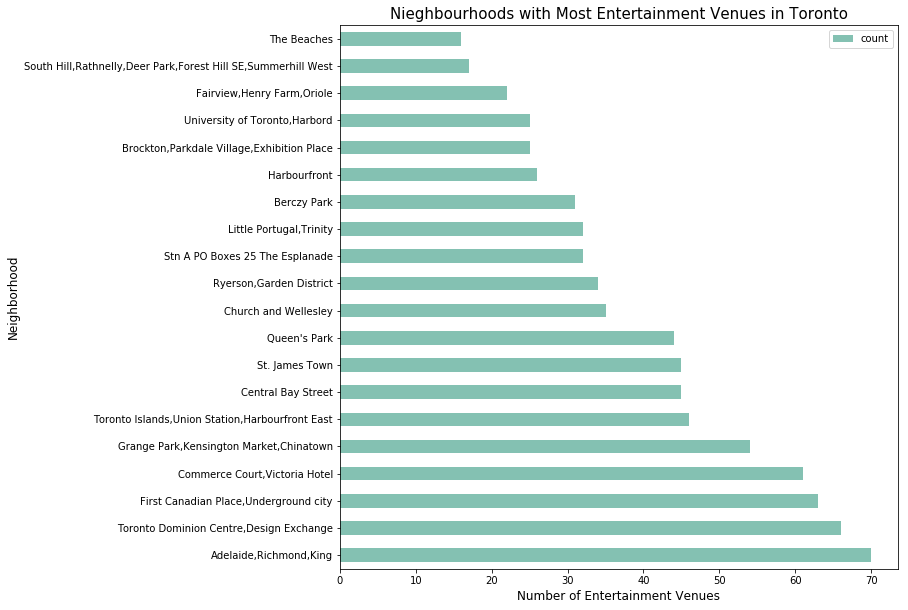

In [348]:
#now create the bar plot 
all_entertainment_ordered_20.plot('Neighborhood','count',kind='barh',figsize=(10,10),color=(0.2, 0.6, 0.5, 0.6))
plt.ylabel("Neighborhood",fontsize=12)
plt.xlabel("Number of Entertainment Venues",fontsize=12)
plt.title('Nieghbourhoods with Most Entertainment Venues in Toronto',fontsize=15)


<h3> College & University Places Nearby 

<h4> In order to save time we will use the same function to retrive all the venues hereon

In [19]:
all_collage=getNearbyRestaurants(names=df_neighbourhood['Neighbourhood'], latitudes=df_neighbourhood['Latitude'], longitudes=df_neighbourhood['Longitude'], radius=1000, categoryId='4d4b7105d754a06372d81259')

In [20]:
all_collage.head()                                                                                                                                                                    

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,restaurant,restaurant Latitude,restaurant Longitude,restaurant Category
0,"Malvern,Rouge",43.806686,-79.194353,Evergreen College,43.802162,-79.199654,College Academic Building
1,"Highland Creek,Port Union,Rouge Hill",43.784535,-79.160497,UTSC - Physics Labs,43.780079,-79.156193,College Lab
2,"Highland Creek,Port Union,Rouge Hill",43.784535,-79.160497,st brendan catholic school,43.783052,-79.149267,College Gym
3,"Morningside,West Hill,Guildwood",43.763573,-79.188711,Z Cups Etc,43.767973,-79.188123,Community College
4,"Morningside,West Hill,Guildwood",43.763573,-79.188711,Boys and Girls Club of East Scarborough,43.757549,-79.193691,Student Center


In [21]:
#group by neighbouhood 
all_collage_grouped=all_collage.groupby('Neighborhood').size().to_frame('count').reset_index()
all_collage_grouped.reset_index(inplace=True)
all_collage_grouped.head()

,index,Neighborhood,count
0,0,Agincourt,7
1,1,"Bathurst Manor,Wilson Heights,Downsview North",1
2,2,"Bedford Park,Lawrence Manor East",2
3,3,Berczy Park,28
4,4,"Birch Cliff,Cliffside West",4


In [22]:
#first order the data frame, in descending order, in terms of number of entertainment venues 
all_collage_ordered=all_collage_grouped.sort_values(by='count',ascending=False)
all_collage_ordered.head(20)
all_collage_ordered_20=all_collage_ordered.iloc[0:20]

Text(0.5, 1.0, 'Nieghbourhoods with Most College & University Venues in Toronto')

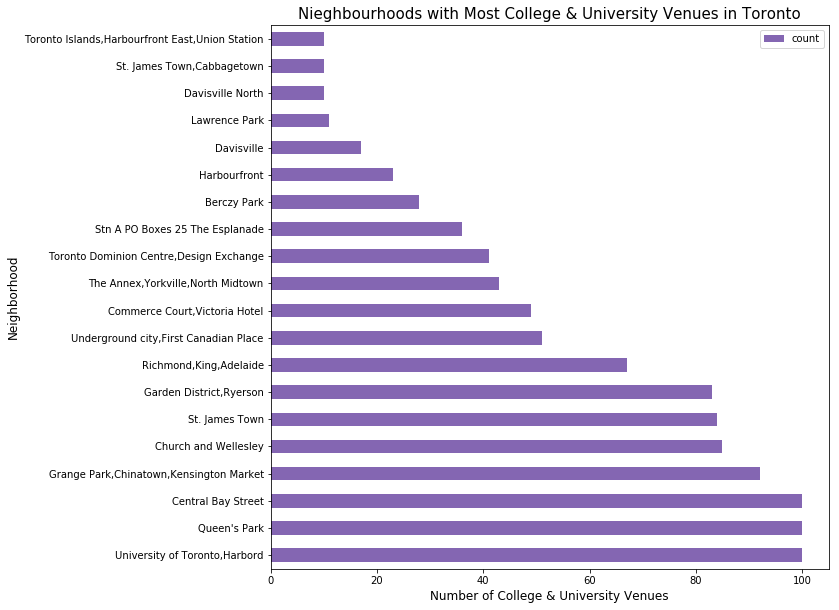

In [23]:
#now create the bar plot 
all_collage_ordered_20.plot('Neighborhood','count',kind='barh',figsize=(10,10),color=(0.2, 0.0, 0.5, 0.6))
plt.ylabel("Neighborhood",fontsize=12)
plt.xlabel("Number of College & University Venues",fontsize=12)
plt.title('Nieghbourhoods with Most College & University Venues in Toronto',fontsize=15)

<h3> Professional & Other Places Venues  

In [372]:
all_other=getNearbyRestaurants(names=df_neighbourhood['Neighbourhood'], latitudes=df_neighbourhood['Latitude'], longitudes=df_neighbourhood['Longitude'], radius=1000, categoryId='4d4b7105d754a06375d81259')

In [390]:
all_other.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,restaurant,restaurant Latitude,restaurant Longitude,restaurant Category
0,"Malvern,Rouge",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
1,"Malvern,Rouge",43.806686,-79.194353,Allstate Insurance: Lisa Kristine Dzuba,43.799837,-79.197306,Office
2,"Malvern,Rouge",43.806686,-79.194353,Allstate Insurance: Muhammad Atif Qaseem,43.799837,-79.197306,Office
3,"Malvern,Rouge",43.806686,-79.194353,Allstate Insurance: Scarborough East Agency,43.799837,-79.197306,Office
4,"Malvern,Rouge",43.806686,-79.194353,Allstate Insurance: Yolanda Santos,43.799837,-79.197306,Office


In [374]:
#group by neighbouhood 
all_other_grouped=all_other.groupby('Neighborhood').size().to_frame('count').reset_index()
all_other_grouped.reset_index(inplace=True)
all_other_grouped.head()

,index,Neighborhood,count
0,0,"Adelaide,Richmond,King",100
1,1,Agincourt,10
2,2,"Alderwood,Long Branch",15
3,3,Bayview Village,8
4,4,"Bedford Park,Lawrence Manor East",18


In [379]:
#first order the data frame, in descending order, in terms of number of entertainment venues 
all_other__ordered=all_other_grouped.sort_values(by='count',ascending=False)
all_other__ordered.head(20)
all_other_ordered_20=all_other__ordered.iloc[0:20]

Text(0.5, 1.0, 'Nieghbourhoods with Most Professional & Other Places Venues in Toronto')

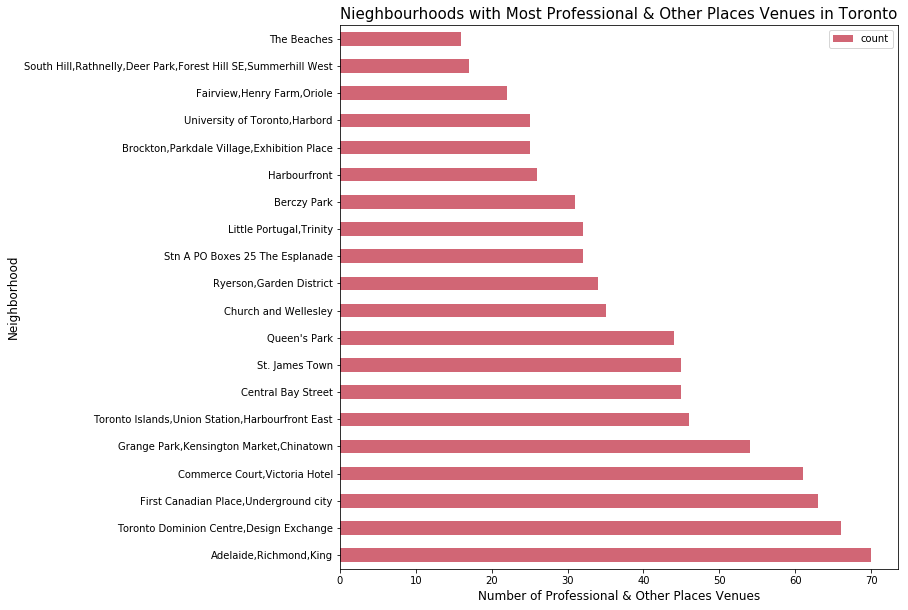

In [388]:
#now create the bar plot 
all_schools_ordered_20.plot('Neighborhood','count',kind='barh',figsize=(10,10),color=(0.7, 0.0, 0.1, 0.6))
plt.ylabel("Neighborhood",fontsize=12)
plt.xlabel("Number of Professional & Other Places Venues",fontsize=12)
plt.title('Nieghbourhoods with Most Professional & Other Places Venues in Toronto',fontsize=15)


<h3> Outdoors & Recreation Venues  

In [389]:
all_rec=getNearbyRestaurants(names=df_neighbourhood['Neighbourhood'], latitudes=df_neighbourhood['Latitude'], longitudes=df_neighbourhood['Longitude'], radius=1000, categoryId='4d4b7105d754a06377d81259')

In [392]:
all_rec.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,restaurant,restaurant Latitude,restaurant Longitude,restaurant Category
0,"Malvern,Rouge",43.806686,-79.194353,MMA World Academy,43.800259,-79.195227,Martial Arts Dojo
1,"Malvern,Rouge",43.806686,-79.194353,Upper Rouge Trail,43.809988,-79.186147,Trail
2,"Malvern,Rouge",43.806686,-79.194353,Fit4Less,43.800135,-79.198683,Gym
3,"Malvern,Rouge",43.806686,-79.194353,Mr. Lawnmower Landscaping Services Ltd,43.805515,-79.182292,Garden
4,"Rouge Hill,Highland Creek,Port Union",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course


In [393]:
#group by neighbouhood 
all_rec_grouped=all_rec.groupby('Neighborhood').size().to_frame('count').reset_index()
all_rec_grouped.reset_index(inplace=True)
all_rec_grouped.head()

,index,Neighborhood,count
0,0,"Adelaide,Richmond,King",94
1,1,Agincourt,4
2,2,"Alderwood,Long Branch",6
3,3,Bayview Village,3
4,4,"Bedford Park,Lawrence Manor East",4


In [395]:
#first order the data frame, in descending order, in terms of number of entertainment venues 
all_rec__ordered=all_rec_grouped.sort_values(by='count',ascending=False)
all_rec__ordered.head(20)
all_rec_ordered_20=all_other__ordered.iloc[0:20]

Text(0.5, 1.0, 'Nieghbourhoods with Outdoors & Recreation Venues in Toronto')

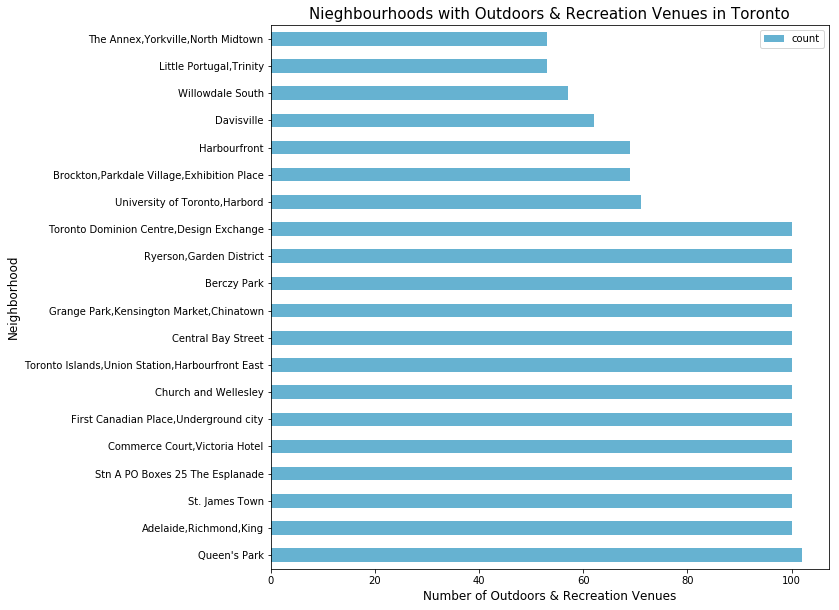

In [413]:
#now create the bar plot 
all_rec_ordered_20.plot('Neighborhood','count',kind='barh',figsize=(10,10),color=(0.0, 0.5, 0.7, 0.6))
plt.ylabel("Neighborhood",fontsize=12)
plt.xlabel("Number of Outdoors & Recreation Venues",fontsize=12)
plt.title('Nieghbourhoods with Outdoors & Recreation Venues in Toronto',fontsize=15)


<h1><span style="color:blue"> EXPLORING POPULATION TRENDS </span><h1>

<h2> Importing the csv file with the data 

In [245]:
# The code was removed by Watson Studio for sharing.

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [246]:
df_population=df_data_0

<h3> Data Cleaning

In [247]:
df_new_pop=df_population.drop(['Category','Data Source','Topic','City of Toronto','_id'],axis=1)
df_new_pop.set_index(['Characteristic'],inplace=True)
df_trans_pop=df_new_pop.transpose()
df_trans_pop.dropna()
df_trans_pop.head()

Characteristic,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,Children (0-14 years),...,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants
Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,"3,840",...,605,"27,490","18,865","8,610","5,445","3,170",880,735,135,"2,280"
Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,"3,075",...,490,"22,325","13,565","8,775","5,610","3,145",980,760,220,"2,170"
Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,"1,760",...,70,"11,370","8,235","3,130","2,200",925,680,615,70,245
Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,"2,360",...,835,"27,715","12,980","14,735","8,340","6,390","3,930","2,630","1,310","2,460"
Banbury-Don Mills,42,No Designation,"27,695","26,918",2.90%,"12,473","12,124","2,775",9.98,"3,605",...,380,"25,925","16,300","9,625","6,480","3,140","1,405","1,190",220,"1,735"


In [248]:
df_trans_pop.reset_index(inplace=True)
df_trans_pop.head()

Characteristic,index,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,...,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants
0,Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,...,605,"27,490","18,865","8,610","5,445","3,170",880,735,135,"2,280"
1,Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,...,490,"22,325","13,565","8,775","5,610","3,145",980,760,220,"2,170"
2,Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,...,70,"11,370","8,235","3,130","2,200",925,680,615,70,245
3,Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,...,835,"27,715","12,980","14,735","8,340","6,390","3,930","2,630","1,310","2,460"
4,Banbury-Don Mills,42,No Designation,"27,695","26,918",2.90%,"12,473","12,124","2,775",9.98,...,380,"25,925","16,300","9,625","6,480","3,140","1,405","1,190",220,"1,735"


In [249]:
df_trans_pop.rename(columns={'Characteristic':'index','index':'Neighbourhood'},inplace=True)
df_trans_pop['Population, 2016']= df_trans_pop['Population, 2016'].str.replace(',', '').astype(float)
df_trans_pop.head()

Characteristic,Neighbourhood,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,...,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants
0,Agincourt North,129,No Designation,29113.0,"30,279",-3.90%,"9,371","9,120","3,929",7.41,...,605,"27,490","18,865","8,610","5,445","3,170",880,735,135,"2,280"
1,Agincourt South-Malvern West,128,No Designation,23757.0,"21,988",8.00%,"8,535","8,136","3,034",7.83,...,490,"22,325","13,565","8,775","5,610","3,145",980,760,220,"2,170"
2,Alderwood,20,No Designation,12054.0,"11,904",1.30%,"4,732","4,616","2,435",4.95,...,70,"11,370","8,235","3,130","2,200",925,680,615,70,245
3,Annex,95,No Designation,30526.0,"29,177",4.60%,"18,109","15,934","10,863",2.81,...,835,"27,715","12,980","14,735","8,340","6,390","3,930","2,630","1,310","2,460"
4,Banbury-Don Mills,42,No Designation,27695.0,"26,918",2.90%,"12,473","12,124","2,775",9.98,...,380,"25,925","16,300","9,625","6,480","3,140","1,405","1,190",220,"1,735"


In [251]:
df_trans_pop['Total income: Average amount ($)']=df_trans_pop['Total income: Average amount ($)'].str.replace(',', '').astype(float)

In [215]:
# The code was removed by Watson Studio for sharing.

<h2> Importing the geojson file

In [268]:
from ibm_botocore.client import Config
import ibm_boto3

cos=ibm_boto3.client(service_name='s3',
                     ibm_api_key_id=credentials['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials['ENDPOINT'])

In [269]:
cos.download_file(Bucket=credentials['BUCKET'],Key='simple.geojson',Filename='simple.geojson')

<h3> Exploring the Population Distribution

In [270]:
tO_geo=r'simple.geojson'
tO_pop_Map=folium.Map(location=[43.6532, -79.3832],zoom_start=12)
tO_pop_Map.choropleth(
    geo_data=tO_geo,
    data=df_trans_pop,
    columns=['Neighbourhood','Population, 2016'],
    key_on='feature.properties.HOOD',
    threshold_scale=[6000, 16000, 26000, 36000, 56000, 66000],
    fill_color='Greens',
    fill_opacity=0.9,
    line_opacity=0.4,
    legend_name='Population of Toronto',
)
tO_pop_Map

<h3> Exploring the income distributon

In [267]:
tO_geo=r'simple.geojson'
tO_pop_income_Map=folium.Map(location=[43.6532, -79.3832],zoom_start=12)
tO_pop_income_Map.choropleth(
    geo_data=tO_geo,
    data=df_trans_pop,
    columns=['Neighbourhood','Total income: Average amount ($)'],
    key_on='feature.properties.HOOD',
    threshold_scale=[25000, 72000, 120000, 170000, 215000, 260000,310000],
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name='Income Distribution of Toronto',
)
tO_pop_income_Map